# Flexible RO Multiperiod/Pricetaker Workflow

This tutorial will show how to optimize the cost of a pricetaker model given a dataset of price signals and the system's operating conditions (start date, end date, flow rate, minimum recovery, etc.). See the [IDAES Pricetaker Documentation](https://github.com/IDAES/idaes-pse/blob/main/docs/reference_guides/apps/grid_integration/multiperiod/Price_Taker.rst) for more details.

### Important files
 - **flowsheet**: contains the functions needed for the construction of a flexible desalination flowsheet with cost expressions
 - **utils**: contains utility functions to streamline the workflow
 - **params**: contains the default values of all the required parameters
 - **PriceTakerModel**: contains the pricetaker model, where pricetakers are entities that must accept market prices since they lack the market share to directly influence the market price. When coupled with the multi-period modeling, this model is able to synthesize grid-centric modeling with steady-state, process-centric modeling:

## Step 1: Import libraries from pandas, pyomo, and IDAES

In [1]:
from idaes.apps.grid_integration import PriceTakerModel
import pandas as pd
import pyomo.environ as pyo
from watertap.flowsheets.flex_desal import flowsheet as fs
from watertap.flowsheets.flex_desal import utils
from watertap.flowsheets.flex_desal.params import FlexDesalParams

## Step 2: Interpret price signal data from the .csv

In [2]:
price_data = pd.read_csv("sbce_pricesignal.csv")
price_data["Energy Rate"] = (
    price_data["electric_energy_0_2022-07-05_2022-07-14_0"]
    + price_data["electric_energy_1_2022-07-05_2022-07-14_0"]
    + price_data["electric_energy_2_2022-07-05_2022-07-14_0"]
    + price_data["electric_energy_3_2022-07-05_2022-07-14_0"]
)
price_data["Fixed Demand Rate"] = price_data[
    "electric_demand_maximum_2022-07-05_2022-07-14_0"
]
price_data["Var Demand Rate"] = price_data[
    "electric_demand_peak-summer_2022-07-05_2022-07-14_0"
]
price_data["Emissions Intensity"] = 0
price_data["Customer Cost"] = price_data["electric_customer_0_2022-07-05_2022-07-14_0"]

## Step 3: Create an instance of the PriceTakerModel

In [3]:
m = PriceTakerModel()

# Instantiate an object containing the model parameters
m.params = FlexDesalParams(
    start_date="2022-07-05 00:00:00",
    end_date="2022-07-15 00:00:00",
    annual_production_AF=3125,  # acrft/yr
)
m.params.intake.nominal_flowrate = 1063.5  # m3/hr
m.params.ro.update(
    {
        "startup_delay": 8,  # hours
        "minimum_downtime": 4,  # hours
        "nominal_flowrate": 337.670,  # m3/hr
        "surrogate_type": "quadratic_surrogate",
        "surrogate_a": 11.509,
        "surrogate_b": -10.269,
        "surrogate_c": 5.627,
        "surrogate_d": 0,
        "minimum_recovery": 0.4,
        "nominal_recovery": 0.465,
        "maximum_recovery": 0.52,
        "allow_variable_recovery": True,
    }
)

# Append LMP data to the model
m.append_lmp_data(lmp_data=price_data["Energy Rate"])

## Step 4: Build the multiperiod model

In [4]:
m.build_multiperiod_model(
    flowsheet_func=fs.build_desal_flowsheet,
    flowsheet_options={"params": m.params},
)

# Update the time-varying parameters other than the LMP, such as
# demand costs and emissions intensity. LMP value is updated by default
m.update_operation_params(
    {
        "fixed_demand_rate": price_data["Fixed Demand Rate"],
        "variable_demand_rate": price_data["Var Demand Rate"],
        "emissions_intensity": price_data["Emissions Intensity"],
        "customer_cost": price_data["Customer Cost"],
    }
)

2025-11-23 16:00:13 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Found minimum uptime/downtime data for reverse_osmosis.ro_skid[1] - Adding minimum uptime/downtime constraints.
2025-11-23 16:00:13 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  reverse_osmosis.ro_skid[1] at ro_skid_1_startup_shutdown.
2025-11-23 16:00:13 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Found minimum uptime/downtime data for reverse_osmosis.ro_skid[2] - Adding minimum uptime/downtime constraints.
2025-11-23 16:00:13 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  reverse_osmosis.ro_skid[2] at ro_skid_2_startup_shutdown.
2025-11-23 16:00:13 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Found minimum uptime/downtime data for reverse_osmosis.ro_skid[3] - Adding minimum uptime/downtime constraints.
2025-11

## Step 5: Add constraints from the flowsheet (fs)

In [5]:
# Add demand cost and fixed cost calculation constraints
fs.add_demand_and_fixed_costs(m)

# Add the startup delay constraints
fs.add_delayed_startup_constraints(m)

## Step 6: Construct useful expressions or model-level constraints

In [6]:
m.total_water_production = pyo.Expression(
    expr=m.params.timestep_hours * sum(m.period[:, :].posttreatment.product_flowrate)
)
m.total_energy_cost = pyo.Expression(expr=sum(m.period[:, :].energy_cost))
m.total_demand_cost = pyo.Expression(expr=m.fixed_demand_cost + m.variable_demand_cost)
m.total_customer_cost = pyo.Expression(
    expr=sum(m.period[:, :].customer_cost) * m.params.num_months
)
m.total_electricity_cost = pyo.Expression(
    expr=m.total_energy_cost + m.total_demand_cost + m.total_customer_cost
)

## Step 7: Fix operation variables that do not vary with time 

In [7]:
# Feed flow to the intake does not vary with time
m.fix_operation_var("intake.feed_flowrate", m.params.intake.nominal_flowrate)
# Pretreatment is either active (1) or inactive (0) for the entire run
m.fix_operation_var("pretreatment.op_mode", 1)

## Step 8: Call the flowsheet function that constrains water production based on the water production target

In [8]:
fs.constrain_water_production(m)

## Step 9: Call the objective function to minimize operating costs

In [9]:
# If water recovery is static, it must be fixed
if not m.params.ro.allow_variable_recovery:
    utils.fix_recovery(m, recovery=m.params.ro.nominal_recovery)

m.obj = pyo.Objective(
    expr=m.total_energy_cost + m.total_demand_cost,
    sense=pyo.minimize,
)

In [10]:
# # Use the following code to optimize net profit
# m.add_hourly_cashflows(
#     revenue_streams=["water_revenue", "demand_response_revenue"],
#     operational_costs=["emissions_cost", "energy_cost"],
# )
# m.add_overall_cashflows(
#     other_costs=[m.fixed_demand_cost, m.variable_demand_cost, m.fixed_monthly_cost]
# )

# m.add_objective_function(objective_type="net_profit")

## Step 10: Call Gurobi to solve the optimization problem. If a Gurobi license is not available, try resorting to a different solver

In [11]:
solver_name = "gurobi"
# solver_name = "baron"
# solver_name = "scip"
# solver_name = "cplex"
mip_gap = 0.03

if solver_name == "gurobi":
    # solver = utils.get_gurobi_solver_model(m, mip_gap=0.005)
    solver = pyo.SolverFactory("gurobi")
    solver.options["MIPGap"] = mip_gap
    solver.solve(m, tee=True)

elif solver_name == "scip":
    solver = pyo.SolverFactory("scip", validate=False)
    solver.solve(m, tee=True)

elif solver_name in ["baron", "cplex"]:
    solver = pyo.SolverFactory("gams")
    solver.solve(
        m, tee=True, solver=solver_name, add_options=[f"options optcr={mip_gap};"]
    )

Read LP format model from file C:\Users\RADHAK~1\AppData\Local\Temp\tmp_5tap42c.pyomo.lp
Reading time = 0.11 seconds
x1: 44150 rows, 48003 columns, 138288 nonzeros
Set parameter MIPGap to value 0.03
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i9-13950HX, instruction set [SSE2|AVX|AVX2]
Thread count: 24 physical cores, 32 logical processors, using up to 32 threads

Non-default parameters:
MIPGap  0.03

Optimize a model with 44150 rows, 48003 columns and 138288 nonzeros
Model fingerprint: 0x2d4ccb20
Model has 8640 quadratic constraints
Variable types: 37443 continuous, 10560 integer (10560 binary)
Coefficient statistics:
  Matrix range     [1e-02, 1e+03]
  QMatrix range    [1e+00, 1e+01]
  QLMatrix range   [1e+00, 1e+01]
  Objective range  [3e-02, 1e+00]
  Bounds range     [4e-01, 3e+00]
  RHS range        [1e+00, 2e+05]
  QRHS range       [6e+00, 6e+00]
Presolve removed 25601 rows and 21925 columns
Presolve tim

## Step 11: Compile results

{'fixed_demand_cost': 5657.947123229198,
 'variable_demand_cost': 1071.5952179965097,
 'fixed_monthly_cost': 247096.7741935484,
 'total_water_production': 105606.1643835605,
 'total_energy_cost': 70789.91210717938,
 'total_demand_cost': 6729.542341225708,
 'total_customer_cost': 1177.3419354838923,
 'total_electricity_cost': 78696.79638388898}

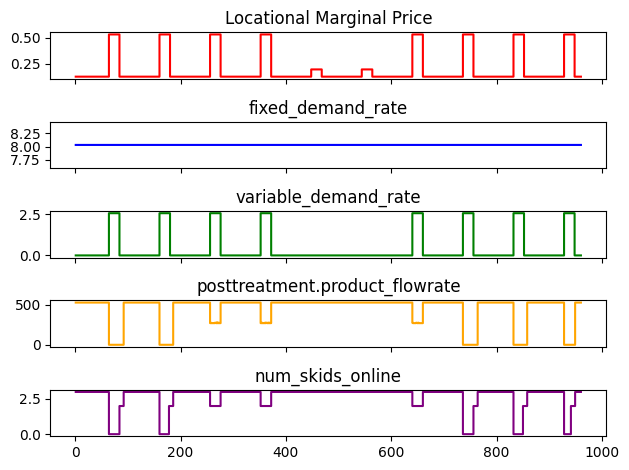

In [12]:
# Write optimal values of all operational variables to a csv file
m.get_operation_var_values().to_csv("dummy_result.csv")

# Plot operational variables
fig, axs = m.plot_operation_profile(
    [
        "fixed_demand_rate",
        "variable_demand_rate",
        "posttreatment.product_flowrate",
        "num_skids_online",
    ],
)

# Return the values of all variables and expressions that do not vary with time
m.get_design_var_values()